# Regression

In [1]:
# Data Manipulation
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Data-Viz
import matplotlib.pyplot as plt
import seaborn as sns

# OLS
import statsmodels.api as sm
from patsy import dmatrices

# Metrics
from sklearn.metrics import (
    r2_score,
    mean_squared_error   
)

## Reading data

In [2]:
train = pd.read_csv('../data/regression_data/regression_train.csv')
train

,target,X1,X2,X3,X4,X5,X6,X7
0,NaN,-0.546168,NaN,47.063305,1.611370,-65.882137,0,-16.672865
1,47.735389,3.074317,-2.836000,49.396649,0.261998,-66.570716,0,-6.664599
2,NaN,-1.485531,-13.102537,42.367991,3.991558,-67.108014,8,-30.790962
3,908.202209,6.907396,-0.308967,57.228787,0.256771,-66.181266,5,-0.726072
4,1640.461863,1.916788,3.460290,51.703375,2.463790,-65.143663,5,8.131680
...,...,...,...,...,...,...,...,...
1037,4296.426459,5.375810,6.937947,55.810467,1.698025,-65.819509,8,16.304176
1038,54.530919,0.619207,-1.925819,48.168606,1.357223,-65.385243,8,-4.525675
1039,1636.535078,4.548172,2.886253,47.775525,1.278439,-56.312543,8,6.782694
1040,NaN,1.806045,-3.015213,48.352707,4.627906,-57.722688,5,-7.085751


In [3]:
train.isna().mean()

target    0.313820
X1        0.000000
X2        0.010557
X3        0.000000
X4        0.000000
X5        0.000000
X6        0.000000
X7        0.000000
dtype: float64

In [4]:
test = pd.read_csv('../data/regression_data/regression_test.csv')
test

,target,X1,X2,X3,X4,X5,X6,X7
0,3.436244,0.210854,-2.451307,51.239996,4.641751,-67.874319,5,-5.760571
1,1525.839412,2.157483,4.337776,43.828794,8.070219,-68.405526,8,10.193773
2,455.600191,5.166359,-0.452615,43.931305,1.349625,-66.240021,0,-1.063645
3,0.619759,3.276641,-3.607201,50.631046,2.473542,-69.971690,8,-8.476921
4,10.996472,-1.867485,-2.408863,58.660224,2.826219,-53.647149,5,-5.660827
...,...,...,...,...,...,...,...,...
256,555.785223,5.099614,-0.648889,54.770941,1.975509,-61.664039,8,-1.524890
257,624.578115,0.220241,1.410877,42.895015,0.639779,-66.077209,0,3.315561
258,NaN,1.066213,-5.569022,51.318035,1.994699,-64.081511,0,-13.087202
259,NaN,-2.260013,-10.854081,38.671378,1.065288,-66.732946,0,-25.507091


In [5]:
test.isna().mean()

target    0.310345
X1        0.000000
X2        0.000000
X3        0.000000
X4        0.000000
X5        0.000000
X6        0.000000
X7        0.000000
dtype: float64

Como temos muito NA's na própria variável "target", iremos apenas remover as linhas que contém esses NA's. O nosso objetivo é criar um regressor da variável target, sem ela não adianta as informações providenciadas pelas outras colunas.

In [6]:
train.dropna(inplace=True)
test.dropna(inplace=True)

## EDA

<AxesSubplot:>

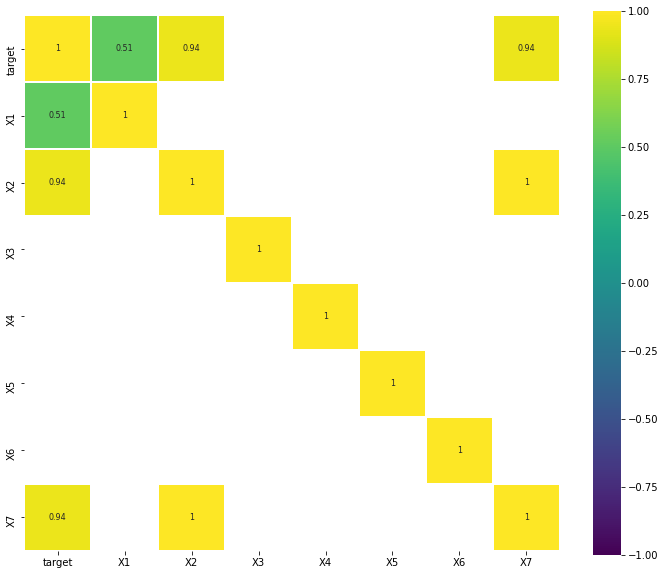

In [7]:
corr = train.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(corr[abs(corr) > 0.4],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

Distribuição da única variável discreta do conjunto.

(array([213.,   0.,   0.,   0.,   0.,   0., 248.,   0.,   0., 254.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

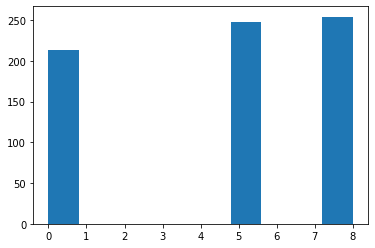

In [8]:
plt.hist(train['X6'])

(array([407., 152.,  72.,  39.,  19.,  10.,   4.,   8.,   2.,   2.]),
 array([6.25508304e-02, 1.03830324e+03, 2.07654394e+03, 3.11478463e+03,
        4.15302532e+03, 5.19126602e+03, 6.22950671e+03, 7.26774740e+03,
        8.30598809e+03, 9.34422879e+03, 1.03824695e+04]),
 <BarContainer object of 10 artists>)

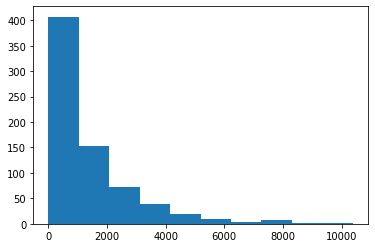

In [9]:
plt.hist(train['target'])

## Modelling

## Ordinary Least Squares (OLS)

Inicialmente, iremos modelar usando Regressão Linear Múltipla, onde se assume que a variável 'target' tem distribuição normal, além de assumir variância única para todas as observações. Porém, já tem-se suspeita de que não é um modelo adequado dado que a nossa variável 'target' não tem as características de uma distribuição normal: falta de simetria, etc.

In [10]:
from scipy import stats
fitted_data, lambda_value = stats.boxcox(train['target'])
train['target'] = fitted_data
test['target'] = stats.boxcox(test['target'], lmbda= lambda_value)

In [11]:
train['const'] = 1
reg = sm.OLS(endog=train['target'], exog=train.drop(columns=['target']),
             missing='drop', hasconst=True)
results = reg.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     1799.
Date:                Sat, 08 May 2021   Prob (F-statistic):               0.00
Time:                        23:41:28   Log-Likelihood:                -1442.7
No. Observations:                 715   AIC:                             2899.
Df Residuals:                     708   BIC:                             2931.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X1             0.5424      0.026     20.574      0.0

/home/adriel_martins/.cache/pypoetry/virtualenvs/desafio-oncase-Lx6s8YPY-py3.8/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


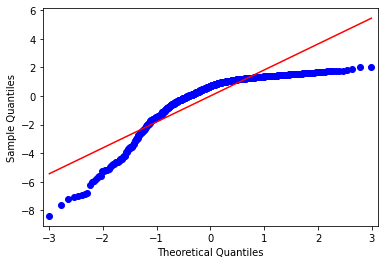

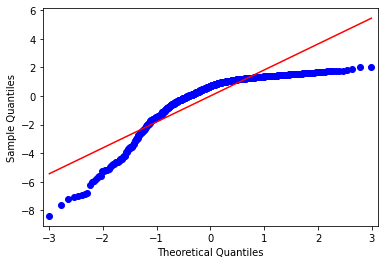

In [12]:
sm.qqplot(results.resid, line='s')

Como podemos ver, não podemos confiar na nossa hipótese de distribuição gaussiana para a variável target, pois temos que se isso foste verdadeiro, os resíduos gerados pelo modelo também teriam distribuição gaussiana, o que não é verdade. Consequentemente, não podemos confiar nas estimativas para a variância de cada coeficiente, e nem podemos confiar no teste t ou teste marginal para identificar se aquele coeficiente é sequer importante.

Sendo assim, iremos realizar **Regressão Bootstrap**. Ou seja, iremos amostrar N amostras B vezes e para cada b-ésima vez iremos estimar os parâmetros da regressão. Essas amostras são _com reposição_. Sendo assim, teremos uma distribuição empírica que nos trará confiança sobre as conclusões inferenciais que traremos sobre ela. O valor que escolheremos de N será do próprio tamanho da amostra original.

In [13]:
class OLS_Bootstrap:
    def _get_regression_coef(self, train):
        reg = sm.OLS(endog=train['target'], exog=train.drop(columns=['target']),
                     missing='drop')
        results = reg.fit()

        return results.params

    def _bootstrap_regression_coef(self, data, B):
        boot_df = pd.DataFrame()
        for B in np.arange(B):
            data_b = data.sample(frac=1, replace=True)
            reg_coef_b = self._get_regression_coef(data_b).T
            boot_df = pd.concat([boot_df, reg_coef_b], axis=1)

        boot_df.columns = ['B' + str(i) for i in np.arange(B+1)]

        return boot_df.T
    
    def fit(self, data, B):
        self.boot_df = self._bootstrap_regression_coef(data, B)
        self.params = self.boot_df.mean()
        self._train_data = data
        self.resid = self.predict() - data['target']
    
    def confidence_intervals(self, p=0.05):
        return self.boot_df.quantile(q=[p/2, 1-(p/2)], axis=0)
    
    def predict(self, new_data=None):
        if new_data is None:
            new_data = self._train_data
            
        X = new_data.loc[:, self.boot_df.mean().index.tolist()]
        beta = self.boot_df.mean()
        y_pred = np.matmul(X.values, beta.values)
            
        return y_pred

In [14]:
ols_boot = OLS_Bootstrap()
ols_boot.fit(train, B=1000)
ols_boot.boot_df

,X1,X2,X3,X4,X5,X6,X7,const
B0,0.566177,0.294215,0.184122,-0.207037,-0.006514,-0.001361,0.691405,2.813666
B1,0.516369,0.303608,0.150432,-0.194938,-0.004923,0.048275,0.713480,4.497053
B2,0.551570,0.296213,0.147686,-0.209874,-0.013791,0.017463,0.696100,4.088044
B3,0.523405,0.306810,0.171610,-0.201755,-0.002497,0.046096,0.721004,3.549810
B4,0.501807,0.293191,0.167443,-0.255561,-0.008214,0.026990,0.688998,3.725926
...,...,...,...,...,...,...,...,...
B995,0.537584,0.305123,0.156203,-0.233129,-0.010518,-0.001853,0.717040,3.898113
B996,0.564656,0.309232,0.170309,-0.237842,-0.009643,0.002752,0.726696,3.335639
B997,0.534106,0.299908,0.159374,-0.219202,-0.004578,0.018265,0.704784,4.183812
B998,0.510198,0.299999,0.142082,-0.204456,-0.019355,0.028047,0.704997,4.097870


array([[<AxesSubplot:title={'center':'X1'}>,
        <AxesSubplot:title={'center':'X2'}>,
        <AxesSubplot:title={'center':'X3'}>],
       [<AxesSubplot:title={'center':'X4'}>,
        <AxesSubplot:title={'center':'X5'}>,
        <AxesSubplot:title={'center':'X6'}>],
       [<AxesSubplot:title={'center':'X7'}>,
        <AxesSubplot:title={'center':'const'}>, <AxesSubplot:>]],
      dtype=object)

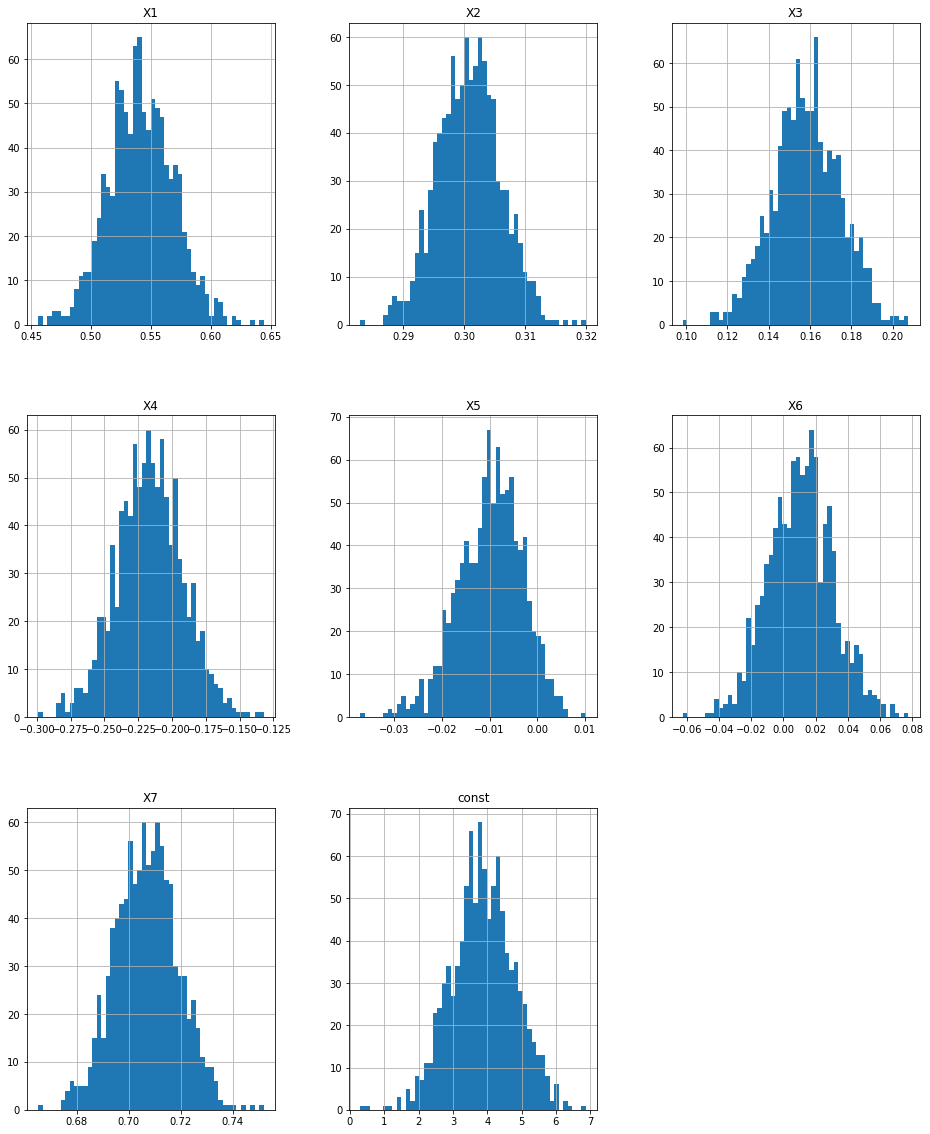

In [15]:
ols_boot.boot_df.hist(figsize=(16, 20), bins=50)

Uma vez tendo encontrado a distribuição empírica dos coeficientes, iremos agora buscar um intervalo de confiança e também realizar um teste de hipótese se os coeficientes são zero ao nível de significância de 5%.

### Teste de Hipótese e Intervalo de Confiança

In [16]:
ols_boot.confidence_intervals()

,X1,X2,X3,X4,X5,X6,X7,const
0.025,0.489493,0.290862,0.126231,-0.265534,-0.024525,-0.026979,0.683526,2.119700
0.975,0.596058,0.310838,0.189066,-0.168636,0.002259,0.050361,0.730468,5.659556


Vemos que os coeficientes X6 e a constante são estatisticamente 0 ao nível de significância de 5%. Portanto, iremos rodar novamente a nossa regressão bootstrap sem essas variávéis. Além disso, iremos realizar o teste de hipótese novamente.

In [17]:
ols_boot.fit(train.drop(columns=['X6', 'X5']), B = 1000)
ols_boot.boot_df

,X1,X2,X3,X4,X7,const
B0,0.507170,0.299378,0.141212,-0.200948,0.703538,5.480585
B1,0.511319,0.302811,0.167316,-0.199888,0.711607,4.032885
B2,0.550571,0.297185,0.142473,-0.204751,0.698384,5.342698
B3,0.572624,0.304491,0.139336,-0.233475,0.715554,5.339878
B4,0.553469,0.299491,0.167374,-0.196856,0.703803,4.019436
...,...,...,...,...,...,...
B995,0.528662,0.295424,0.161497,-0.208848,0.694247,4.575572
B996,0.537747,0.301203,0.179504,-0.196564,0.707828,3.362698
B997,0.530321,0.300531,0.136543,-0.222699,0.706248,5.726753
B998,0.579931,0.298526,0.175522,-0.265371,0.701537,3.724423


array([[<AxesSubplot:title={'center':'X1'}>,
        <AxesSubplot:title={'center':'X2'}>],
       [<AxesSubplot:title={'center':'X3'}>,
        <AxesSubplot:title={'center':'X4'}>],
       [<AxesSubplot:title={'center':'X7'}>,
        <AxesSubplot:title={'center':'const'}>]], dtype=object)

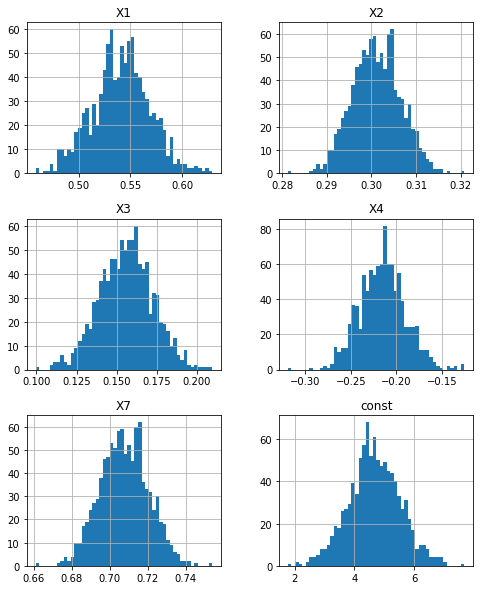

In [21]:
ols_boot.boot_df.hist(figsize=(8, 10), bins=50)

In [18]:
ols_boot.confidence_intervals()

,X1,X2,X3,X4,X7,const
0.025,0.484667,0.29083,0.122767,-0.262856,0.683451,2.954834
0.975,0.595548,0.31154,0.188347,-0.166149,0.732119,6.401361


Como podemos ver todas as nossas variáveis são estatisticamente significantes, ao nível de significância de 5%.

### Predição do Modelo

Como sabemos pela teoria de bootstrap, temos que a média da distribuição empírica é um estimador não viezado e de variância mínima para o valor esperado da distribuição empírica. Ou seja, um bom estimador para os nossos coeficientes. Usaremos ele, portanto.

(array([ 7.,  4.,  6., 12., 10.,  4.,  6.,  6., 12.,  7.,  8.,  9.,  2.,
         4.,  6.,  9., 10.,  4.,  3.,  9.,  5.,  3.,  7.,  2.,  2.,  2.,
         3.,  3.,  1.,  1.,  3.,  0.,  1.,  1.,  2.,  0.,  1.,  2.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 6.65728306,  7.30670093,  7.95611881,  8.60553668,  9.25495455,
         9.90437243, 10.5537903 , 11.20320817, 11.85262605, 12.50204392,
        13.15146179, 13.80087967, 14.45029754, 15.09971541, 15.74913329,
        16.39855116, 17.04796903, 17.69738691, 18.34680478, 18.99622265,
        19.64564053, 20.2950584 , 20.94447627, 21.59389415, 22.24331202,
        22.89272989, 23.54214777, 24.19156564, 24.84098351, 25.49040139,
        26.13981926, 26.78923713, 27.43865501, 28.08807288, 28.73749075,
        29.38690863, 30.0363265 , 30.68574437, 31.33516225, 31.98458012,
        32.63399799, 33.28341587, 33.93283374, 34.58225161, 35.23166949,
        35.88108736, 36.53050523, 37.17992311, 37.82934098,

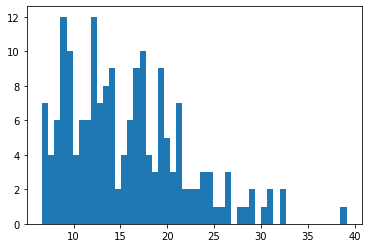

In [22]:
test['const'] = 1
y_pred = ols_boot.predict(new_data=test)
plt.hist(y_pred, bins=50)

### Metrics

In [23]:
print(f"R2: {r2_score(test['target'], y_pred)}")
print(f"MRSE: {mean_squared_error(test['target'], y_pred)}")
print(f"Cor(y, y_pred): {np.corrcoef(test['target'], y_pred)[0,1]}")

R2: 0.9330294217244867
MRSE: 3.1636625322124194
Cor(y, y_pred): 0.9679851619347065


### Importância das variáveis

Iremos checar a importância individual de cada variável em relação a variável 'target'. Iremos fazer isto de duas maneiras:

1. Iremos retirar cada variável independentemente e depois computar score R2 e medir a diferença com e sem a variável.
2. Calcularemos o módulo da padronização do coeficiente que nos dirá comparativamente quem tem mais impacto marginal perante a variável 'target'.

In [27]:
def get_r2_score(X, beta, y):
    y_pred = np.matmul(X.values, beta.values)
    return r2_score(y, y_pred)
    
predict_from_bootstrap(boot_df, train)

NameError: name 'predict_from_bootstrap' is not defined

## XGBoost

Para termos uma comparação com outro modelo e vermos se chegamos a um resultado semelhante. Usaremos o modelo de árvores de decisão, em especial, o ensemble de árvores que é o XGBoost.

In [26]:
from xgboost import XGBRegressor
xgb_r = XGBRegressor(objective ='reg:squarederror',
                        n_estimators = 10, seed = 123)
  
# Fitting the model
xgb_r.fit(train.drop(columns=['target']),
          train['target'])
  
# Predict the model
y_pred = xgb_r.predict(test.drop(columns=['target']).values)

print(f"R2: {r2_score(test['target'], y_pred)}")
print(f"MRSE: {mean_squared_error(test['target'], y_pred)}")
print(f"Cor(y, y_pred): {np.corrcoef(test['target'], y_pred)[0,1]}")

R2: 0.9788583094874586
MRSE: 0.9987247514422859
Cor(y, y_pred): 0.9924983115423709


/home/adriel_martins/.cache/pypoetry/virtualenvs/desafio-oncase-Lx6s8YPY-py3.8/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
